## ANALISIS DE SENTIMIENTOS CONTEXTO PERU

## Librerias

In [1]:
#import warnings
#warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

#NLTK
import nltk
from nltk import word_tokenize, WordPunctTokenizer, regexp_tokenize
from nltk import word_tokenize, WordPunctTokenizer, regexp_tokenize

#Plotting 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

#Keras
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

C:\Users\claud\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Funcion para cambiar valores de polaridad
def Cambiar_valor_polaridad(x):
    result = 0
    if x == 'POS':
        result = 1
    elif x == 'NEG':
        result = 0
    elif x == 'NEU':
        result =  -1
    return result

# DATASET PROPIO

In [104]:
from sklearn.model_selection import train_test_split
df = pd.read_csv("DF_pandemiaE.csv")
df = df[['id','tweet','target']]
print(len(df))
df = df[df['target'].isin(['POS','NEG'])]
print(len(df))
#df['polarity_value'] = df['target'].apply(lambda x: Cambiar_valor_polaridad(x))
#df = df[df['target'].isin(['POS','NEG','NEU'])]
#X_train, X_test, y_train, y_test = train_test_split(df[['id','tweet','target']], df['target'], stratify=df['target'], test_size=0.30)

2819
2019


In [4]:
#X_train, X_test, y_train, y_test = cross_validation.train_test_split(Data, Target, test_size=0.3, random_state=0, stratify=Target)

In [105]:
df['target'].value_counts()

NEG    1302
POS     717
Name: target, dtype: int64

# Processing Tweets

Merge both datasets for pre-processing.

In [107]:
#processed_tweets= pd.concat([pd.DataFrame({'tweetID':tweets.id, 'tweetText':tweets.tweet,'polarity_value':tweets.target, 'set':tweets.set}), 
#                             pd.DataFrame({'tweetID':train_set.tweet_id, 'tweetText':train_set.tweetText, 'polarity_value':train_set.polarity_value,'set':train_set.set})], ignore_index=True)
#processed_tweets= pd.concat([pd.DataFrame({'tweetID':df_pandemia_train.id, 'tweetText':df_pandemia_train.tweet,'polarity_value':df_pandemia_train.target, 'set':df_pandemia_train.set}),
#                             pd.DataFrame({'tweetID':df_pandemia_test.id, 'tweetText': df_pandemia_test.tweet, 'polarity_value':df_pandemia_test.target,'set':df_pandemia_test.set})], ignore_index=True)
processed_tweets = df.copy()
processed_tweets['processed_tweet'] = df.tweet
#processed_tweets['processed_tweet'] = processed_tweets.tweetText
processed_tweets.sample(4)

id                                              tweet  \
2079  1489751199700115459  @PedroCastilloTe no comprende que la expectati...   
2128  1537161967818919936  Grave amenaza del ministro @FelixCheroM contra...   
2498  1300074380697927681  @ToniAlvaL @congresoperu Ministra, llama la at...   
872   1233242985107730437  @jevedel @RPPNoticias Muchas gracias mi querid...   

     target                                    processed_tweet  
2079    NEG  @PedroCastilloTe no comprende que la expectati...  
2128    NEG  Grave amenaza del ministro @FelixCheroM contra...  
2498    NEG  @ToniAlvaL @congresoperu Ministra, llama la at...  
872     POS  @jevedel @RPPNoticias Muchas gracias mi querid...

### Hashtags

In [108]:
import re
hash_regex = re.compile(r"#(\w+)")
hstgs = [] # To store the hashtags so we can exclude them from some parts of the analysis
def hash_repl(match):
    _ = '__HASH_'+match.group(1).upper()
    hstgs.append(_)
    return _

### User names

In [109]:
user_regex = re.compile(r"@(\w+)")
usr_names = [] # To store the user names so we can exclude them from some parts of the analysis
def user_repl(match):
    _ = '__user_'+match.group(1).upper()
    usr_names.append(_)
    return _

### URLs

In [151]:
url_regex = re.compile(r"(http|https|ftp)://[a-zA-Z0-9\./]+")
def url_repl(match):
    return '__URL_'

In [152]:
#processed_tweets['processed_tweet'] = [re.sub(url_regex, url_repl, str(s)) for s in processed_tweets.processed_tweet]
#processed_tweets

id                                              tweet  \
0     1222241238092582914  Ministra @EHinostrozaP: "Trabajamos en brindar...   
1     1222241227548045316  Desde #Independencia │ Mejoramos los servicios...   
2     1233130926697304064  También constató la operatividad del servicio ...   
3     1233100540827049987  En el Día del Tecnólogo Médico saludamos a los...   
4     1255271689119846401  #LaSaludNosUne Un total de 1.2 toneladas de eq...   
...                   ...                                                ...   
2814  1554675632306470912   Tampoco se pasen, pues!  https://t.co/DJukDmuRyT   
2815  1554555115259961347                                        Qué bandido   
2816  1554509240613703685                              Ahí vamos nuevamente…   
2817  1554241053107953664  @ReloadPalza @BlackDeMenta Recontra falso ese ...   
2818  1554155370469269505  @DiegoAcuOficial No hay duda sobre las infracc...   

     target                                    processed_tweet emojis_unicode  \
0       POS  ['ministr', '__user_EHINOSTROZAP', 'trabaj', '...      [U+1F923]   
1       POS  ['desd', '__HASH_INDEPENDENCIA', 'mejor', 'los...             []   
2       POS  ['tambien', 'constat', 'operat', 'del', 'servi...             []   
3       POS  ['dia', 'del', 'tecnolog', 'medic', 'salud', '...      [U+1F44F]   
4       POS  ['__HASH_LASALUDNOSUNE', 'total', 'tonel', 'eq...      [U+1F4F2]   
...     ...                                                ...            ...   
2814    NEG  ['tampoc', 'pas', 'pues', '__PUNC_EXCL', '__UR...             []   
2815    NEG                                    ['que', 'band']             []   
2816    POS              ['ahi', 'vam', 'nuev', '__PUNC_ELLP']             []   
2817    NEG  ['__user_RELOADPALZA', '__user_BLACKDEMENTA', ...             []   
2818    NEG  ['__user_DIEGOACUOFICIAL', 'hay', 'dud', 'sobr...             []   

     emojis_categories                           processed_tweet_features  
0      [face-positive]  {'has(ministr)': 1, 'has(__user_EHINOSTROZAP)'...  
1          [no_emojis]  {'has(desd)': 1, 'has(__HASH_INDEPENDENCIA)': ...  
2          [no_emojis]  {'has(tambien)': 1, 'has(constat)': 1, 'has(op...  
3               [body]  {'has(dia)': 1, 'has(del)': 1, 'has(tecnolog)'...  
4              [phone]  {'has(__HASH_LASALUDNOSUNE)': 1, 'has(total)':...  
...                ...                                                ...  
2814       [no_emojis]  {'has(tampoc)': 1, 'has(pas)': 1, 'has(pues)':...  
2815       [no_emojis]  {'has(que)': 1, 'has(band)': 1, 'has(que,band)...  
2816       [no_emojis]  {'has(ahi)': 1, 'has(vam)': 1, 'has(nuev)': 1,...  
2817       [no_emojis]  {'has(__user_RELOADPALZA)': 1, 'has(__user_BLA...  
2818       [no_emojis]  {'has(__user_DIEGOACUOFICIAL)': 1, 'has(hay)':...  

[2019 rows x 7 columns]

### Reppppppppetitions

In [112]:
# Repeating words like hurrrryyyyyy
rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE);
def rpt_repl(match):
    return match.group(1)+match.group(1)

In [113]:
# Test
re.sub(rpt_regex, rpt_repl, "Reppppeated characters in wordsssssssss" )

'Reppeated characters in wordss'

### Punctuation

In [114]:
# Spliting by word boundaries
word_bound_regex = re.compile(r"\W+")

# Punctuations
punctuations = \
	[	#('',		['.', ] )	,\
		#('',		[',', ] )	,\
		#('',		['\'', '\"', ] )	,\
		('__PUNC_EXCL',		['!', '¡', ] )	,\
		('__PUNC_QUES',		['?', '¿', ] )	,\
		('__PUNC_ELLP',		['...', '…', ] )	,\
	]

#For punctuation replacement
def punctuations_repl(match):
	text = match.group(0)
	repl = []
	for (key, parr) in punctuations :
		for punc in parr :
			if punc in text:
				repl.append(key)
	if( len(repl)>0 ) :
		return ' '+' '.join(repl)+' '
	else :
		return ' '

In [115]:
processed_tweets['processed_tweet'] = [re.sub(word_bound_regex, punctuations_repl, str(s)) for s in processed_tweets.processed_tweet]

### Stemming
As there is no spanish language for PorterStemmer, go with snowball!

In [116]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

In [117]:
# Test
text = processed_tweets.processed_tweet[245]
print(text)
text = [word if(word[0:2]=='__') else word.lower() for word in text.split() if ((len(word) >= 3) and (word not in usr_names))]
text = [stemmer.stem(w) for w in text]                
text = " ".join(text)
print('------------------')
print(text)

En el frente están primeros Su espada el conocimiento Blanco y rojo sentimiento de la salud sus guerreros Hoy en el DíaMundialDeLaSalud mi reconocimiento y respaldo a ustedes nuestros HéroesDeLaSalud https t co 6HjCAcw2on
------------------
frent estan primer espad conoc blanc roj sentimient salud sus guerrer hoy diamundialdelasalud reconoc respald usted nuestr heroesdelasalud https 6hjcacw2on


In [118]:
def sb_stem(text, only_first=0):
    text = [word if(word[0:2]=='__') else word.lower() for word in text.split() if ((len(word) >= 3) or (word in ['no','si', 'sí', 'ni']))] #   If we are doing negation analysis, maybe is a better idea to keep the small words (like 'no')
    text = [stemmer.stem(w) if w[0:2]!='__' else w for w in text ]
    
    return(text)

In [119]:
processed_tweets['processed_tweet'] = processed_tweets.processed_tweet.apply(sb_stem)

In [120]:
def processAll(text):
    text = re.sub( hash_regex, hash_repl, text )
    text = re.sub( user_regex, user_repl, text)
    text = re.sub( url_regex, url_repl, text )
    
    text = text.replace('\'','')
    
    text = re.sub( word_bound_regex , punctuations_repl, text )
    text = re.sub( rpt_regex, rpt_repl, text )
    
    text = sb_stem(text)    
    return text

### Process tweets

Now we can process the tweets with the recently created functions

In [121]:
processed_tweets['processed_tweet'] = processed_tweets.tweet.apply(processAll)

In [122]:
#check
#processed_tweets.sample(4)

## Feature Creation

### Emoticons

Emojis on the Spanish tweets, unlike on the Colombian ones, are stored as combinations of characters, such as :) . We will try to put them all on the same page for the feature engineering. That is, we will translate them to their Unicode value. Let's begin with the spanish ones.

In [123]:
# Emoticons
emoticons = \
	[	# For __EMOT_SMILEY
        (' __emoji: U+1F601',	[':-)', ':)', '(:', '(-:', ] )	,\
        # for __EMOT_LAUGH
		(' __emoji: U+1F923',		[':-D', ':D', 'X-D', 'XD', 'xD', ] )	,\
        # For __EMOT_LOVE
		(' __emoji: U+2764',		['<3', ':\*', ] )	,\
        # For __EMOT_WINK
		('__emoji: U+1F609',		[';-)', ';)', ';-D', ';D', '(;', '(-;', ] )	,\
        # For __EMOT_FROWN
		(' __emoji: U+2639',		[':-(', ':(', '(:', '(-:', ] )	,\
        # For __EMOT_CRY
		(' __emoji: U+1F622',		[':,(', ':\'(', ':"(', ':(('] )	,\
	]
    
def escape_paren(arr):
	return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]

def regex_union(arr):
	return '(' + '|'.join( arr ) + ')'

emoticons_regex = [ (repl, re.compile(regex_union(escape_paren(regx))) ) for (repl, regx) in emoticons ]

In [124]:
# Test
text = "This is a text with one emoticon :) and another :("
for (repl, regx) in emoticons_regex :
    text = re.sub(regx, ' '+repl+' ', text)
    
print(text)

This is a text with one emoticon   __emoji: U+1F601  and another   __emoji: U+2639 


Now we can do something similar for the Colombian tweets, we will translate them to their respective  unicode values:

In [125]:
# data scraped from http://www.unicode.org/emoji/charts/full-emoji-list.html
emojis_db=pd.read_csv('emojis_db_csv.csv')
emojis_db.head()

emoji_category  number     code                 CLDR_Short_Name
0  face-positive       1  U+1F600                   grinning face
1  face-positive       2  U+1F601  beaming face with smiling eyes
2  face-positive       3  U+1F602          face with tears of joy
3  face-positive       4  U+1F923   rolling on the floor laughing
4  face-positive       5  U+1F603     grinning face with big eyes

In [126]:
emojis_db.emoji_category.unique()

array(['face-positive', 'face-neutral', 'face-negative', 'face-sick',
       'face-role', 'face-fantasy', 'cat-face', 'monkey-face', 'person',
       'person-role', 'person-fantasy', 'person-gesture',
       'person-activity', 'person-sport', 'family', 'body', 'hair-style',
       'emotion', 'clothing', 'animal-mammal', 'animal-bird',
       'animal-amphibian', 'animal-reptile', 'animal-marine',
       'animal-bug', 'plant-flower', 'plant-other', 'food-fruit',
       'food-vegetable', 'food-prepared', 'food-asian', 'food-sweet',
       'drink', 'dishware', 'place-map', 'place-geographic',
       'place-building', 'place-religious', 'place-other',
       'transport-ground', 'transport-water', 'transport-air', 'hotel',
       'time', 'sky & weather', 'event', 'award-medal', 'sport', 'game',
       'arts & crafts', 'sound', 'music', 'musical-instrument', 'phone',
       'computer', 'light & video', 'book-paper', 'money', 'mail',
       'writing', 'office', 'lock', 'tool', 'science', 'medi

Emojis present on tweets on the colombian dataset are encoded as the actual emoji image, the following function will extract the unicode from each emoji so we can use it as a feature.

In [127]:
def emojis_unicode(tweet):
    ''' Extracts the emojis on the tweet on Unicode format, also tries to match those in regular format, such as ";)" '''
    for (repl, regx) in emoticons_regex :
        tweet = re.sub(regx, ' '+repl+' ', tweet)
#     print(tweet)

    tweet_unicode = str(tweet.encode('unicode-escape'))
    tweet_unicode = tweet_unicode.replace('\\\\U000',' __emoji: U+')
#     print(tweet_unicode)
    
    emoji_list = []
#     print(tweet)
    for emoji in range(tweet_unicode.count(' __emoji: ')):
        em = tweet_unicode.split('__emoji: ')[emoji+1].split()[0]
        em = em[:7] # the len of the emoji in unicode is between 6 and 7
        emoji_list.append(em.upper())
    return emoji_list

In [128]:
# Test
text = "This is a text with one emoticon :) and another :( and some others: 😡 🤣😂"
emojis_unicode(text)

['U+1F601', 'U+2639', 'U+1F621', 'U+1F923', 'U+1F602']

In [129]:
processed_tweets['emojis_unicode'] = processed_tweets.tweet.apply(emojis_unicode) # np.vectorize(emojis_unicode)(processed_tweets['tweetText'])

Now we can get the category of the extracted emojis

In [130]:
def emoji_category(emojis):
    categories = []
    for i in range(len(emojis)):
        # print(emojis[i])
        try:
            categories.append(emojis_db.loc[emojis_db.code == emojis[i]].emoji_category.values[0])
        except:
            try:
                _ = emojis[i].split('+')[1] + '+'
                categories.append(emojis_db[emojis_db.code.str.contains(_)].emoji_category.values[0])
            except:
                categories.append('other')
    if len(categories) < 1:
        categories.append('no_emojis')
    return categories

emoji_category(emojis_unicode(text))

['face-positive',
 'face-negative',
 'face-negative',
 'face-positive',
 'face-positive']

In [131]:
processed_tweets['emojis_categories'] = processed_tweets.emojis_unicode.apply(emoji_category)

In [132]:
processed_tweets.head()

id                                              tweet  \
0  1222241238092582914  Ministra @EHinostrozaP: "Trabajamos en brindar...   
1  1222241227548045316  Desde #Independencia │ Mejoramos los servicios...   
2  1233130926697304064  También constató la operatividad del servicio ...   
3  1233100540827049987  En el Día del Tecnólogo Médico saludamos a los...   
4  1255271689119846401  #LaSaludNosUne Un total de 1.2 toneladas de eq...   

  target                                    processed_tweet emojis_unicode  \
0    POS  [ministr, __user_EHINOSTROZAP, trabaj, brind, ...      [U+1F923]   
1    POS  [desd, __HASH_INDEPENDENCIA, mejor, los, servi...             []   
2    POS  [tambien, constat, operat, del, servici, teles...             []   
3    POS  [dia, del, tecnolog, medic, salud, los, profes...      [U+1F44F]   
4    POS  [__HASH_LASALUDNOSUNE, total, tonel, equip, pr...      [U+1F4F2]   

  emojis_categories  
0   [face-positive]  
1       [no_emojis]  
2       [no_emojis]  
3            [body]  
4           [phone]

### N-grams

In [133]:
# Unigrams
unigrams_fd = nltk.FreqDist()
# unigrams_fd.update(text)
# unigrams_fd

# Bigrams
# words_bi  = [ ','.join(map(str,bg)) for bg in nltk.bigrams(text) ]
bi_grams_fd = nltk.FreqDist()
# bi_grams_fd.update( words_bi )
# bi_grams_fd

# Trigrams
# words_tri  = [ ','.join(map(str,tg)) for tg in nltk.trigrams(text) ]
tri_grams_fd = nltk.FreqDist()
# tri_grams_fd.update( words_tri )
# tri_grams_fd

In [134]:
# Wrapper function that encloses all the n-grams procedures
def get_word_features(words):
    bag = {}
    words_uni = [ 'has(%s)'% ug for ug in words ]
    words_bi  = [ 'has(%s)'% ','.join(map(str,bg)) for bg in nltk.bigrams(words) ]
    words_tri = [ 'has(%s)'% ','.join(map(str,tg)) for tg in nltk.trigrams(words) ]
    
    for f in words_uni+words_bi+words_tri:
        bag[f] = 1

    return bag

### Negation

In [135]:
sb_stem('nunca no nada ningún ninguno ninguna tampoco')

['nunc', 'no', 'nad', 'ningun', 'ningun', 'ningun', 'tampoc']

In [136]:
negtn_regex = re.compile( r"""(?:
    ^(?:nunca|no|nada|ningún|ninguno|ninguna|tampoco|
        nunc|nad|ningun|tampoc
    )$
)
|
n't
""", re.X)

def get_negation_features(words):
    INF = 0.0
    negtn = [ bool(negtn_regex.search(w)) for w in words ]

    left = [0.0] * len(words)
    prev = 0.0
    for i in range(0,len(words)):
        if( negtn[i] ):
            prev = 1.0
        left[i] = prev
        prev = max( 0.0, prev-0.1)

    right = [0.0] * len(words)
    prev = 0.0
    for i in reversed(range(0,len(words))):
        if( negtn[i] ):
            prev = 1.0
        right[i] = prev
        prev = max( 0.0, prev-0.1)

    return dict( zip(
                    ['neg_l('+w+')' for w in  words] + ['neg_r('+w+')' for w in  words],
                    left + right ) )

In [137]:
# Test
text = ["Este","tweet", "no", "es", "positivo"]
get_negation_features(text)

{'neg_l(Este)': 0.0,
 'neg_l(tweet)': 0.0,
 'neg_l(no)': 1.0,
 'neg_l(es)': 0.9,
 'neg_l(positivo)': 0.8,
 'neg_r(Este)': 0.8,
 'neg_r(tweet)': 0.9,
 'neg_r(no)': 1.0,
 'neg_r(es)': 0.0,
 'neg_r(positivo)': 0.0}

### Polarity

We tried using the spanish sentiment lexicon from http://www.opener-project.eu/ but it didn't improve the results on any of the algorithms. Maybe due to the fact that spanish from Spain is different from the spanish spoken in Colombia.

In [138]:
opener_lexicon = pd.read_csv('https://raw.githubusercontent.com/opener-project/public-sentiment-lexicons/master/propagation_lexicons/es/es.lemma.sy.an.hypo.rels.maxdepth5.seed500.maj.gold.csv', sep=';', header=None)
opener_lexicon.columns = ['x','pos', 'polarity', 'xx','word','xxx']
opener_lexicon.head()

x pos  polarity   xx                word  xxx
0  unknown   n  positive  1.0        felicitación    1
1  unknown   a  negative  1.0        inconsciente    1
2  unknown   n   neutral  1.0             soporte    1
3  unknown   n   neutral  1.0  proceso_matemático    1
4  unknown   v  positive  1.0          manifestar    1

As the meaning of columns 4 and 6 is not known by us at the moment, they won't be included on the analysis.

In [139]:
def get_sent(polarity):
    if polarity == 'neutral':
        return 0
    if polarity == 'negative':
        return -1
    if polarity == 'positive':
        return 1
opener_lexicon['sentiment'] = opener_lexicon.polarity.apply(get_sent)

In [140]:
opener_lexicon['stmd_word'] = opener_lexicon['word'].apply(sb_stem)
opener_lexicon['stmd_word'] = opener_lexicon.stmd_word.apply(lambda x: str(x).replace('[','').replace(']','').replace("'",''))
opener_lexicon = opener_lexicon[['word','stmd_word','sentiment']]
opener_lexicon = opener_lexicon.loc[opener_lexicon.sentiment != 0]
opener_lexicon = opener_lexicon.drop_duplicates()
opener_lexicon.sample(4)

word   stmd_word  sentiment
6803     insensato    insensat       -1.0
178           vano         van       -1.0
3026  robacarteras  robacarter       -1.0
5146      ovaritis    ovaritis       -1.0

In [141]:
def get_polarity_features(text):
    pol = {}
    text = sb_stem(text)
    for word in text:
        try:
            pol["sent("+word+")"] = opener_lexicon.loc[opener_lexicon.stmd_word == word].sentiment.values[0]
        except:
            continue
            
    return pol

_ = processed_tweets.tweet[15]
print('Tweet ',_)
print('Would have the following words and sentiments associated:')
print(get_polarity_features(_))

Tweet  Ministro @victorzamora: Vivimos una epidemia de características que no se veían en muchos años. Una de gran magnitud fue la del cólera en 1991 cuando se registraron cerca de 300 000 casos. Las dimensiones de la actual epidemia son mayores porque son globales.  https://t.co/LwtijqpuXQ
Would have the following words and sentiments associated:
{'sent(viv)': 1.0, 'sent(gran)': -1.0, 'sent(porqu)': 1.0}


### Apply Features

In [142]:
# Wrapper function for the extraction of features
def extract_features(text):
    global usr_names, hstgs
    features = {}
    words = text
    words = processAll(text)

    word_features = get_word_features(words)
    features.update( word_features )

    negation_features = get_negation_features(words)
    features.update( negation_features )
    
    # Sentiment features are not included on the final deliverabe as did not improve results
#     sentiment_features = get_polarity_features(text)
#     features.update(sentiment_features )
    
    emoji_features = emoji_category(emojis_unicode(text))
    emoji_features_dic = dict( zip(['emoji_('+w+')' for w in  emoji_features], emoji_features))
    features.update( emoji_features_dic )
    
    usr_names = list(set(usr_names))
    hstgs = list(set(hstgs))
    return features

In [143]:
processed_tweets['processed_tweet_features'] = processed_tweets.tweet.apply(extract_features)

In [144]:
#processed_tweets.head()

In [145]:
processed_tweets.processed_tweet_features[150]

{'has(estam)': 1,
 'has(super)': 1,
 'has(nuestr)': 1,
 'has(propi)': 1,
 'has(expect)': 1,
 'has(per)': 1,
 'has(vam)': 1,
 'has(por)': 1,
 'has(mas)': 1,
 'has(216)': 1,
 'has(mil)': 1,
 'has(337)': 1,
 'has(vacun)': 1,
 'has(aplic)': 1,
 'has(esta)': 1,
 'has(segund)': 1,
 'has(vacunaton)': 1,
 'has(satisfaccion)': 1,
 'has(tambien)': 1,
 'has(region)': 1,
 'has(cusc)': 1,
 'has(que)': 1,
 'has(met)': 1,
 'has(logr)': 1,
 'has(este)': 1,
 'has(fin)': 1,
 'has(seman)': 1,
 'has(481)': 1,
 'has(__user_MINSA_PERU)': 1,
 'has(estam,super)': 1,
 'has(super,nuestr)': 1,
 'has(nuestr,propi)': 1,
 'has(propi,expect)': 1,
 'has(expect,per)': 1,
 'has(per,vam)': 1,
 'has(vam,por)': 1,
 'has(por,mas)': 1,
 'has(mas,216)': 1,
 'has(216,mil)': 1,
 'has(mil,337)': 1,
 'has(337,vacun)': 1,
 'has(vacun,aplic)': 1,
 'has(aplic,esta)': 1,
 'has(esta,segund)': 1,
 'has(segund,vacunaton)': 1,
 'has(vacunaton,nuestr)': 1,
 'has(nuestr,satisfaccion)': 1,
 'has(satisfaccion,tambien)': 1,
 'has(tambien,por

In [146]:
#processed_tweets.set.value_counts()

In [147]:
processed_tweets

id                                              tweet  \
0     1222241238092582914  Ministra @EHinostrozaP: "Trabajamos en brindar...   
1     1222241227548045316  Desde #Independencia │ Mejoramos los servicios...   
2     1233130926697304064  También constató la operatividad del servicio ...   
3     1233100540827049987  En el Día del Tecnólogo Médico saludamos a los...   
4     1255271689119846401  #LaSaludNosUne Un total de 1.2 toneladas de eq...   
...                   ...                                                ...   
2814  1554675632306470912   Tampoco se pasen, pues!  https://t.co/DJukDmuRyT   
2815  1554555115259961347                                        Qué bandido   
2816  1554509240613703685                              Ahí vamos nuevamente…   
2817  1554241053107953664  @ReloadPalza @BlackDeMenta Recontra falso ese ...   
2818  1554155370469269505  @DiegoAcuOficial No hay duda sobre las infracc...   

     target                                    processed_tweet emojis_unicode  \
0       POS  [ministr, __user_EHINOSTROZAP, trabaj, brind, ...      [U+1F923]   
1       POS  [desd, __HASH_INDEPENDENCIA, mejor, los, servi...             []   
2       POS  [tambien, constat, operat, del, servici, teles...             []   
3       POS  [dia, del, tecnolog, medic, salud, los, profes...      [U+1F44F]   
4       POS  [__HASH_LASALUDNOSUNE, total, tonel, equip, pr...      [U+1F4F2]   
...     ...                                                ...            ...   
2814    NEG           [tampoc, pas, pues, __PUNC_EXCL, __URL_]             []   
2815    NEG                                        [que, band]             []   
2816    POS                      [ahi, vam, nuev, __PUNC_ELLP]             []   
2817    NEG  [__user_RELOADPALZA, __user_BLACKDEMENTA, reco...             []   
2818    NEG  [__user_DIEGOACUOFICIAL, hay, dud, sobr, las, ...             []   

     emojis_categories                           processed_tweet_features  
0      [face-positive]  {'has(ministr)': 1, 'has(__user_EHINOSTROZAP)'...  
1          [no_emojis]  {'has(desd)': 1, 'has(__HASH_INDEPENDENCIA)': ...  
2          [no_emojis]  {'has(tambien)': 1, 'has(constat)': 1, 'has(op...  
3               [body]  {'has(dia)': 1, 'has(del)': 1, 'has(tecnolog)'...  
4              [phone]  {'has(__HASH_LASALUDNOSUNE)': 1, 'has(total)':...  
...                ...                                                ...  
2814       [no_emojis]  {'has(tampoc)': 1, 'has(pas)': 1, 'has(pues)':...  
2815       [no_emojis]  {'has(que)': 1, 'has(band)': 1, 'has(que,band)...  
2816       [no_emojis]  {'has(ahi)': 1, 'has(vam)': 1, 'has(nuev)': 1,...  
2817       [no_emojis]  {'has(__user_RELOADPALZA)': 1, 'has(__user_BLA...  
2818       [no_emojis]  {'has(__user_DIEGOACUOFICIAL)': 1, 'has(hay)':...  

[2019 rows x 7 columns]

In [148]:
import random
import statistics
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

fold = 5
index = list(range(0,len(processed_tweets) - 1))
list_index = random.sample(index, fold)

list_acur = []
for i in list_index:
    X_train, X_test, y_train, y_test = train_test_split(processed_tweets[['id','tweet','processed_tweet','processed_tweet_features']], 
                                                    processed_tweets['target'], stratify=processed_tweets['target'], random_state= i, test_size=0.30)
    
    train_ = X_train
    train_['target'] = y_train
    
    test_ = X_test
    test_['target'] = y_test
    
    train_size = int(train_.shape[0]*0.8)
    sentiment_train_tweets = [(tweet, sentiment) for tweet, sentiment in train_[['tweet', 'target']].values[:train_size]]
    sentiment_train_tweets_full = [(tweet, sentiment) for tweet, sentiment in train_[['tweet', 'target']].values[:train_size]]
    sentiment_validation_tweets = [(tweet, sentiment) for tweet, sentiment in train_[['tweet', 'target']].values[train_size:]]
    sentiment_test_tweets  = [(tweet, sentiment) for tweet, sentiment in test_[['tweet', 'target']].values]
    
    v_train = nltk.classify.apply_features(extract_features,sentiment_train_tweets)
    v_train_full = nltk.classify.apply_features(extract_features,sentiment_train_tweets_full)
    v_validation = nltk.classify.apply_features(extract_features,sentiment_validation_tweets)
    v_test  = nltk.classify.apply_features(extract_features,sentiment_test_tweets)
    
    print('Results Fold ', i)
    nb_classifier = nltk.classify.NaiveBayesClassifier
    #nb_classifier = nltk.classify.SklearnClassifier(MultinomialNB())
    nb_class = nb_classifier.train(v_train)
    #print(v_validation)
    print ("Accuracy of the model = ", nltk.classify.accuracy(nb_class, v_validation))
    
    test_predict = [nb_class.classify(t) for (t,s) in v_test]
    acuracia = accuracy_score(y_test, test_predict)
    print('accuracia', acuracia)
    list_acur.append(acuracia)

print(statistics.mean(list_acur))

Results Fold  287
Accuracy of the model =  0.9257950530035336
accuracia 0.8943894389438944
Results Fold  1104
Accuracy of the model =  0.9151943462897526
accuracia 0.9174917491749175
Results Fold  143
Accuracy of the model =  0.9045936395759717
accuracia 0.8960396039603961
Results Fold  1454
Accuracy of the model =  0.9045936395759717
accuracia 0.9026402640264026
Results Fold  401
Accuracy of the model =  0.9222614840989399
accuracia 0.9075907590759076
0.9036303630363036


# Part 1: Classification - Sentiment Analysis

In [149]:
X_train, X_test, y_train, y_test = train_test_split(processed_tweets[['id','tweet','processed_tweet','processed_tweet_features']], 
                                                    processed_tweets['target'], stratify=processed_tweets['target'], test_size=0.30)

In [150]:
#train_ = processed_tweets.loc[processed_tweets.set == 'train']
#test_ = processed_tweets.loc[processed_tweets.set == 'test']
print(len(X_train),len(X_test))

1413 606


In [49]:
train_ = X_train
train_['target'] = y_train

In [50]:
test_ = X_test
test_['target'] = y_test

In [51]:
len(train_)

1973

In [52]:
len(test_)

846

In [53]:
train_size = int(train_.shape[0]*0.8)
sentiment_train_tweets = [(tweet, sentiment) for tweet, sentiment in train_[['tweet', 'target']].values[:train_size]]
sentiment_train_tweets_full = [(tweet, sentiment) for tweet, sentiment in train_[['tweet', 'target']].values[:train_size]]
sentiment_validation_tweets = [(tweet, sentiment) for tweet, sentiment in train_[['tweet', 'target']].values[train_size:]]
sentiment_test_tweets  = [(tweet, sentiment) for tweet, sentiment in test_[['tweet', 'target']].values]
#sentiment_train_tweets

## Data Preparation

In [54]:
# Apply the data processing and cleaning extraction methodologies
v_train = nltk.classify.apply_features(extract_features,sentiment_train_tweets)
v_train_full = nltk.classify.apply_features(extract_features,sentiment_train_tweets_full)
v_validation = nltk.classify.apply_features(extract_features,sentiment_validation_tweets)
v_test  = nltk.classify.apply_features(extract_features,sentiment_test_tweets)
#type(v_train)

In [55]:
len(v_test)

846

In [56]:
print ("For the tweet = ", train_.tweet.values[10] )
print (" ")
print ("The following features has been created:")
print (" ")
#print (v_train[0][0])

For the tweet =  @Hcoya @DeltaMdelta Qué desagradable, realmente
 
The following features has been created:
 
{'has(interesantisim)': 1, 'has(que)': 1, 'has(aclar)': 1, 'has(med)': 1, 'has(conoc)': 1, 'has(mejor)': 1, 'has(virus)': 1, 'has(enfermed)': 1, 'has(confirm)': 1, 'has(esto)': 1, 'has(necesit)': 1, 'has(vacun)': 1, 'has(poblacion)': 1, 'has(par)': 1, 'has(logr)': 1, 'has(inmun)': 1, 'has(rebañ)': 1, 'has(cov)': 1, 'has(deten)': 1, 'has(pandemi)': 1, 'has(nuev)': 1, 'has(ret)': 1, 'has(dic)': 1, 'has(__user_MINSA_PERU)': 1, 'has(__PUNC_QUES)': 1, 'has(interesantisim,que)': 1, 'has(que,aclar)': 1, 'has(aclar,med)': 1, 'has(med,que)': 1, 'has(que,conoc)': 1, 'has(conoc,mejor)': 1, 'has(mejor,virus)': 1, 'has(virus,enfermed)': 1, 'has(enfermed,confirm)': 1, 'has(confirm,esto)': 1, 'has(esto,necesit)': 1, 'has(necesit,vacun)': 1, 'has(vacun,poblacion)': 1, 'has(poblacion,par)': 1, 'has(par,logr)': 1, 'has(logr,inmun)': 1, 'has(inmun,rebañ)': 1, 'has(rebañ,cov)': 1, 'has(cov,deten)'

## Naive Bayes

In [57]:
nb_classifier = nltk.classify.NaiveBayesClassifier
nb_class = nb_classifier.train(v_train)
#print(v_validation)
print ("Accuracy of the model = ", nltk.classify.accuracy(nb_class, v_validation))

Accuracy of the model =  0.6911392405063291


Accuracy looks good enough, we can try now to train on the whole set and run on the Colombian tweets

In [58]:
#nb_class = nb_classifier.train(v_train_full) 
test_predict = [nb_class.classify(t) for (t,s) in v_test]
#print ("Accuracy of the model = ", nltk.classify.accuracy(nb_class, v_test))
#print(len(test_predict),len(y_test))

846 846


In [59]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, test_predict)

0.7021276595744681

## SVM

In [143]:
from sklearn.svm import LinearSVC
svm_classifier = nltk.classify.SklearnClassifier(LinearSVC())
svm_class = svm_classifier.train(v_train)
#print(v_validation)
print ("Accuracy of the model = ", nltk.classify.accuracy(svm_class, v_validation))

Accuracy of the model =  0.6886075949367089


In [144]:
#nb_class = nb_classifier.train(v_train_full) 
test_predict = [svm_class.classify(t) for (t,s) in v_test]
#print ("Accuracy of the model = ", nltk.classify.accuracy(nb_class, v_test))

In [145]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, test_predict)

0.6891252955082743

## Random Forest

In [146]:
from sklearn.ensemble import RandomForestClassifier
dt_classifier = nltk.classify.SklearnClassifier(RandomForestClassifier())
dt_class = dt_classifier.train(v_train)
#print(v_validation)
print ("Accuracy of the model = ", nltk.classify.accuracy(dt_class, v_validation))

Accuracy of the model =  0.6531645569620254


In [147]:
#nb_class = nb_classifier.train(v_train_full) 
test_predict = [dt_class.classify(t) for (t,s) in v_test]
#print ("Accuracy of the model = ", nltk.classify.accuracy(nb_class, v_test))

In [148]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, test_predict)

0.6572104018912529

# Redes

In [149]:
from sklearn.neural_network import MLPClassifier
dt_classifier = nltk.classify.SklearnClassifier(MLPClassifier())
dt_class = dt_classifier.train(v_train)
#print(v_validation)
print ("Accuracy of the model = ", nltk.classify.accuracy(dt_class, v_validation))

C:\Users\claud\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Accuracy of the model =  0.7189873417721518


In [150]:
#nb_class = nb_classifier.train(v_train_full) 
test_predict = [dt_class.classify(t) for (t,s) in v_test]
#print ("Accuracy of the model = ", nltk.classify.accuracy(nb_class, v_test))

In [151]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, test_predict)

0.7115839243498818

There is no way to measure test accuracy as the colombian tweets are not labeled. Clearly, as our production set is a different kind of Spanish (Colombia Vs. Spain on the test set), classification score shouldn't be expected to be as high on this proof of concept, but here is a random sample for each label:

In [223]:
NB_results

tweet  sentiment
0     (@CIDH @CorteIDH #Peru En investigaciones, el ...        1.0
1     (@GuilleBermejo01 el ex-presidente Sagasti es,...        1.0
2     (Perú siempre peleando la misma batalla contra...        1.0
3     (Vote x Castillo en la segunda vuelta ante la ...        1.0
4     (@willaxtv Ese es el pensamiento fujimorista y...        0.0
...                                                 ...        ...
1711  (El Perú necesita dejar atrás la Constitución ...        1.0
1712  (@VLADIMIR_CERRON Perú esta primero económicam...        0.0
1713  (Sobre #AsambleaConstituyente, la razón porque...        1.0
1714  (@GuilleBermejo01 Qué tal imbecil eres y bruto...        1.0
1715  (@GuilleBermejo01 Maldito Comunista!! CHILE ES...        0.0

[1716 rows x 2 columns]

#### Positive Tweets:

In [222]:
positives = NB_results.loc[NB_results.sentiment == 'P']
# Print a sample of Tweets
sample_size = 10
for tweet in positives.tweet.sample(sample_size):
    print(tweet)

ValueError: a must be greater than 0 unless no samples are taken

#### Negative Tweets:

In [57]:
negatives = NB_results.loc[NB_results.sentiment == 'N']
# Print a sample of Tweets
sample_size = 10
for tweet in negatives.tweet.sample(sample_size):
    print(tweet)

('Tras su derrota, @petrogustavo reconoce el triunfo de @IvanDuque en su discurso y anuncia que hará oposición al próximo gobierno.\n\n#ColombiaDecide2018 🇨🇴', nan)
('ENORME este discurso de @petrogustavo', nan)
('8 millones de colombianos que vamos a cuidar el agua, no al fracking @petrogustavo es un compromiso. gracias por abrirle los ojos al país. #IvanDuqueNoEsMiPresidente #GraciasPetro', nan)
('@petrogustavo Felicitaciones a los colombianos por haber evitado se repitiera la misma tragedia de Venezuela. Comunismo es hambre, miseria y atraso.', nan)
('Oigan y el hijo de @petrogustavo que debía la platica y dijo que pagaba mañana será que se va a hacer el “no heterosexual” ?? Feo eso!! #ColombiaElige2018', nan)
('Estoy destrozado pero este trino es de lo mejor que he leído! Perdieron nuestros hermanos los animales, nuestros recursos naturales, las comunidades ancestrales, pero @petrogustavo fue tremendo guerrero. Miren porqué @piedrahitangela @Pauliina_Mejia https://t.co/DxEr4TZsSM',

### Results of Colombian Election Tweet Sentiment

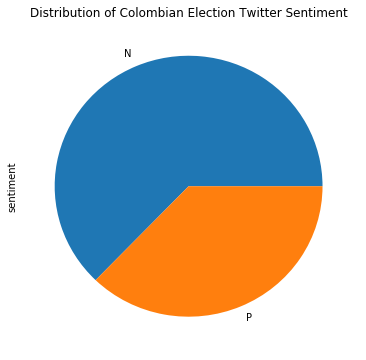

In [58]:
NB_results['sentiment'].value_counts().plot(kind='pie', title="Distribution of Colombian Election Twitter Sentiment", figsize=(6,6))

In [59]:
nb_class.show_most_informative_features(10)

Most Informative Features
            neg_r(felic) = 0.0                 P : N      =     30.5 : 1.0
             has(encant) = 1                   P : N      =     27.5 : 1.0
          has(graci,por) = 1                   P : N      =     27.5 : 1.0
           neg_r(encant) = 0.0                 P : N      =     27.5 : 1.0
           neg_l(encant) = 0.0                 P : N      =     26.5 : 1.0
           has(muy,buen) = 1                   P : N      =     23.5 : 1.0
          has(__HASH_FF) = 1                   P : N      =     20.9 : 1.0
        neg_l(__HASH_FF) = 0.0                 P : N      =     20.9 : 1.0
   emoji_(face-positive) = 'face-positive'      P : N      =     20.7 : 1.0
  has(graci,__PUNC_EXCL) = 1                   P : N      =     20.4 : 1.0


### Max Entropy

We tried with Max-entropy classifier, however better results were achieved with Naive Bayes.

In [66]:
#max_ent_classifier_0 = nltk.classify.MaxentClassifier
#max_ent_class_0 = max_ent_classifier_0.train(v_train, algorithm='GIS', max_iter=25)

In [67]:
#print ("Accuracy of the model = ", nltk.classify.accuracy(max_ent_class_0, v_validation))

# Part 2 : Tweet Text Generation 

### Preprocess Specific Column for Training

In [60]:
#re-load the data
df = pd.read_csv('tweets_mentioning_candidates.csv')

In [61]:
df.head()

tweetID                                          tweetText  \
0  ID:1008504539916455936  Lo mejor del discurso de @IvanDuque es cuando ...   
1  ID:1008504538981191680  @manuelrosalesg @IvanDuque @mluciaramirez Los ...   
2  ID:1008504538242977792  @gloserna @fransupelano @icolombianoo @AlvaroU...   
3  ID:1008504536208683013  @_El_Patriota @petrogustavo @JSantrich_FARC Pa...   
4  ID:1008504534371635201    Que diferencia de discursos! Gracias @IvanDuque   

  urls  tweetRetweetCt  tweetFavoriteCt          tweetSource  \
0   []               0                0   Twitter Web Client   
1   []               0                0  Twitter for Android   
2   []               0                0   Twitter for iPhone   
3   []               0                0  Twitter for Android   
4   []               0                0   Twitter for iPhone   

          tweetCreated                 userID       userScreen  \
0  2018-06-18 00:19:54           ID:533450497        Will_Perz   
1  2018-06-18 00:19:53          ID:1732923980  pablovillasmil1   
2  2018-06-18 00:19:53           ID:965163103     carevalolc87   
3  2018-06-18 00:19:53  ID:952356028263354368         de_gamin   
4  2018-06-18 00:19:52           ID:187162735    camiloparadag   

              userName         userCreateDt  \
0           William PC  2012-03-22 20:05:30   
1    Pablo L Villasmil  2013-09-05 19:44:21   
2    Christian Arevalo  2012-11-22 23:35:40   
3    Calentao De Gamín  2018-01-14 01:45:45   
4  Camilo Parada Gómez  2010-09-05 13:01:58   

                                            userDesc  userFollowerCt  \
0                                                NaN              29   
1        Tecnico Electronico, Opositor hasta la pata             172   
2  Empieza una nueva historia... cambio de trabaj...              54   
3                                                NaN              26   
4  Ortopedista y Traumatólogo. Especialista en Ci...            1618   

   userFriendsCt          userLocation  userTimezone  
0            234                   NaN           NaN  
1            412  Maracaibo, Venezuela           NaN  
2             88                   NaN           NaN  
3             96                   NaN           NaN  
4            633     Bogotá - Colombia           NaN

In [62]:
#Function defintion to preprocess data

#Data Cleaning
import re
def cleaning(s):
    s = str(s)
    s = s.lower()
    s = re.sub('\W,\s',' ',s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+',' ',s)
    s = re.sub('[!#$_]', '', s)
    s = re.sub('[^\\w\\.\\s\\-]+', '', s)
    s = s.replace("https","")
    s = s.replace(",","")
    s = s.replace("[\w*"," ")
    return s

#Extract the username
user_regex = re.compile(r"@(\w+)")
def user_repl(match):
	return '__user_'+match.group(1).upper()


#Replace Emojicons for one word
emoticons = \
	[	('__EMOT_SMILEY',	[':-)', ':)', '(:', '(-:', ] )	,\
		('__EMOT_LAUGH',		[':-D', ':D', 'X-D', 'XD', 'xD', ] )	,\
		('__EMOT_LOVE',		['<3', ':\*', ] )	,\
		('__EMOT_WINK',		[';-)', ';)', ';-D', ';D', '(;', '(-;', ] )	,\
		('__EMOT_FROWN',		[':-(', ':(', '(:', '(-:', ] )	,\
		('__EMOT_CRY',		[':,(', ':\'(', ':"(', ':(('] )	,\
	]
    
def escape_paren(arr):
	return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]

def regex_union(arr):
	return '(' + '|'.join( arr ) + ')'

emoticons_regex = [ (repl, re.compile(regex_union(escape_paren(regx))) ) for (repl, regx) in emoticons ]

In [63]:
#####Apply the functions - be mindful of the order

# Clean the usernames 
df['tweetText'] = [re.sub(user_regex, user_repl, str(s)) for s in df['tweetText']]

# Replace emojis
df['tweetText'] = [re.sub(user_regex, user_repl, str(s)) for s in emoticons_regex and df['tweetText']]

#Clean data - only used tweetText_for_gen column because it doesn't make sense to clean the others
df['tweetText'] = [cleaning(s) for s in df['tweetText']]

## Exploration

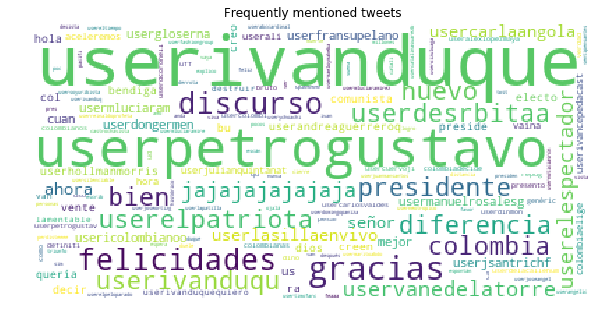

In [12]:
from nltk.corpus import stopwords
import string
#Get an idea about what words are contained
punctuation = list(string.punctuation)
stop = stopwords.words('spanish') + punctuation + ['rt', 'via']
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop,
                          max_words=150,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(df['tweetText']))
plt.imshow(wordcloud)
plt.rcParams["figure.figsize"] = (10,10)
plt.axis('off')
plt.title("Frequently mentioned tweets")
plt.show()

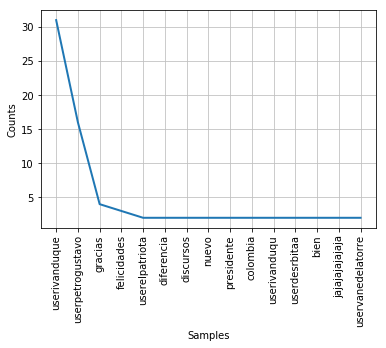

In [64]:
#Frequencies

#Get frequenies - ideally with more data since frequencies are low 
allWords = nltk.tokenize.word_tokenize(str(df['tweetText']))
allWordDist = nltk.FreqDist(w.lower() for w in allWords)

stopwords = nltk.corpus.stopwords.words('spanish')
allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords and len(w) > 3)
allWordExceptStopDist.plot(15)

## Text Generation

In [91]:
# generate a sequence from the model
def generate_seq(model, tokenizer, seed_text, n_words):
	in_text, result = seed_text, seed_text
	# generate a fixed number of words
	for _ in range(n_words):
        
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		encoded = array(encoded)
        
		# predict a word in the vocabulary
		yhat = model.predict_classes(encoded, verbose=0)
        
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text, result = out_word, result + ' ' + out_word
	return result

In [92]:
# source text
data = str(df['tweetText'])

# integer encode text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded = tokenizer.texts_to_sequences([data])[0] #return encoded words in array

In [93]:
# determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1 #dictionary with frequencies of unique words
print('Vocabulary Size: %d' % vocab_size)

# create word -> word sequences
sequences = list()
for i in range(1, len(encoded)):
	sequence = encoded[i-1:i+1]
	sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))

# split into X and y elements
sequences = array(sequences)
X, y = sequences[:,0],sequences[:,1]

Vocabulary Size: 262
Total Sequences: 378


In [94]:
from keras.layers import Dropout

# one hot encode outputs
y = to_categorical(y, num_classes=vocab_size)

# define model
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(Dropout(0.1, input_shape=((468, 321))))
model.add(LSTM(50))
model.add(Dropout(0.1))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1, 10)             2620      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 10)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 262)               13362     
Total params: 28,182
Trainable params: 28,182
Non-trainable params: 0
_________________________________________________________________
None


In [101]:
# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
model.fit(X, y, epochs=500, verbose=2)

Epoch 1/500
 - 1s - loss: 0.8400 - acc: 0.7037
Epoch 2/500
 - 0s - loss: 0.8305 - acc: 0.6825
Epoch 3/500
 - 0s - loss: 0.8329 - acc: 0.6852
Epoch 4/500
 - 0s - loss: 0.7788 - acc: 0.6931
Epoch 5/500
 - 0s - loss: 0.7975 - acc: 0.6958
Epoch 6/500
 - 0s - loss: 0.8161 - acc: 0.6799
Epoch 7/500
 - 0s - loss: 0.8003 - acc: 0.6878
Epoch 8/500
 - 0s - loss: 0.8384 - acc: 0.6534
Epoch 9/500
 - 0s - loss: 0.7829 - acc: 0.7063
Epoch 10/500
 - 0s - loss: 0.7952 - acc: 0.6931
Epoch 11/500
 - 0s - loss: 0.8329 - acc: 0.6905
Epoch 12/500
 - 0s - loss: 0.7892 - acc: 0.7196
Epoch 13/500
 - 0s - loss: 0.8206 - acc: 0.6772
Epoch 14/500
 - 0s - loss: 0.8333 - acc: 0.7011
Epoch 15/500
 - 0s - loss: 0.8035 - acc: 0.7011
Epoch 16/500
 - 0s - loss: 0.8253 - acc: 0.6878
Epoch 17/500
 - 0s - loss: 0.7829 - acc: 0.7037
Epoch 18/500
 - 0s - loss: 0.8115 - acc: 0.6905
Epoch 19/500
 - 0s - loss: 0.8244 - acc: 0.6958
Epoch 20/500
 - 0s - loss: 0.8616 - acc: 0.6667
Epoch 21/500
 - 0s - loss: 0.8192 - acc: 0.6984
E

**Accuracy is not so high but enough for our purposes!**

# Generate your text here!

**It is only able to generate the sequence for the words that are part of the vocabulary. We are currently testing in Beta! **

In [102]:
#pull some frequent words from the vocabulary
allWordExceptStopDist.most_common(10)

[('userivanduque', 31),
 ('userpetrogustavo', 16),
 ('gracias', 4),
 ('felicidades', 3),
 ('userelpatriota', 2),
 ('diferencia', 2),
 ('discursos', 2),
 ('nuevo', 2),
 ('presidente', 2),
 ('colombia', 2)]

In [119]:
string = input("What do you want to test? ")
print(generate_seq(model, tokenizer, string , 5)) #give me 5 words in a sequence

What do you want to test? diferencia
diferencia en los discursos definiti 24




While sentence does not follow correct syntactic rules it serves as an indicator what topics are sourrounding the presidential candidate Duque. It is related to the lack of jornalism for some years. A news agency could pick this hint up and investigate further. 

### Thank you for reading!